# 今天我们来开始入门机器学习，简单介绍一下线性回归模型

**线性回归是线性模型，例如，假设输入变量（x）和单个输出变量（y）之间存在线性关系的模型。**

**更具体地，可以根据输入变量（x）的线性组合来计算输出变量（y）。**


我们希望算法学习假设的参数，以便能够建立方程进行预测
该方程以特征和参数作为输入，并预测其值作为输出

# 1.导入数据集，今天我们所用到的数据集是2017年世界人口幸福指数的数据集

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#导入数据
data = pd.read_csv('2017.csv')

#查看数据集
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 12 columns):
Country                          155 non-null object
Happiness.Rank                   155 non-null int64
Happiness.Score                  155 non-null float64
Whisker.high                     155 non-null float64
Whisker.low                      155 non-null float64
Economy..GDP.per.Capita.         155 non-null float64
Family                           155 non-null float64
Health..Life.Expectancy.         155 non-null float64
Freedom                          155 non-null float64
Generosity                       155 non-null float64
Trust..Government.Corruption.    155 non-null float64
Dystopia.Residual                155 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 14.6+ KB


,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182
5,Netherlands,6,7.377,7.427426,7.326574,1.503945,1.428939,0.810696,0.585384,0.470490,0.282662,2.294804
6,Canada,7,7.316,7.384403,7.247597,1.479204,1.481349,0.834558,0.611101,0.435540,0.287372,2.187264
7,New Zealand,8,7.314,7.379510,7.248490,1.405706,1.548195,0.816760,0.614062,0.500005,0.382817,2.046456
8,Sweden,9,7.284,7.344095,7.223905,1.494387,1.478162,0.830875,0.612924,0.385399,0.384399,2.097538
9,Australia,10,7.284,7.356651,7.211349,1.484415,1.510042,0.843887,0.601607,0.477699,0.301184,2.065211


# 确保数据集没有异常值和缺失值，进行下一步操作
**查看数据这一步很重要**

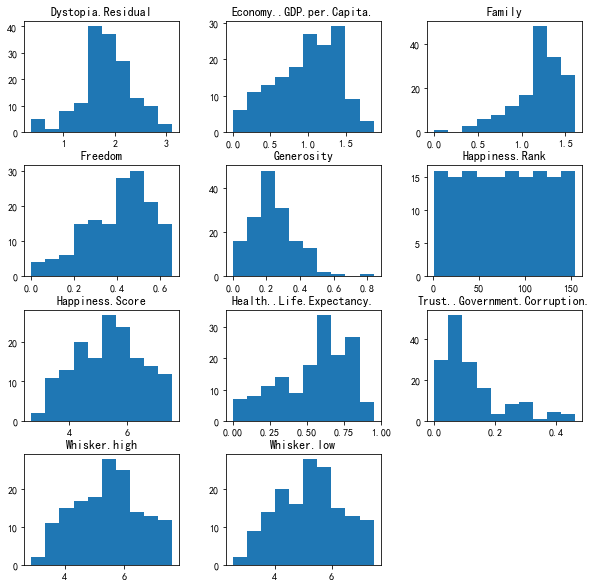

In [3]:
#画出每一个属性的分布直方图
histohrams = data.hist(grid=False, figsize=(10, 10))

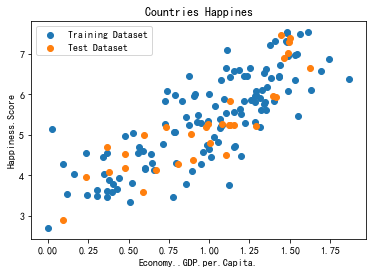

In [4]:
#切分训练集和测试集
#分出80%训练集，20%测试集
#这里没有用到sklearn的train_test_split
train_data = data.sample(frac=0.8)
test_data = data.drop(train_data.index)

x_train = train_data[['Economy..GDP.per.Capita.']].values
y_train = train_data[['Happiness.Score']].values


x_test = test_data[['Economy..GDP.per.Capita.']].values
y_test = test_data[['Happiness.Score']].values

#绘制出散点图
plt.scatter(x_train, y_train, label='Training Dataset')
plt.scatter(x_test, y_test, label='Test Dataset')
plt.xlabel('Economy..GDP.per.Capita.')
plt.ylabel('Happiness.Score')
plt.title('Countries Happines')
plt.legend()
plt.show()

In [5]:
def normalize(features):
    features_normalized = np.copy(features).astype(float)

    features_mean = np.mean(features, 0)

    features_deviation = np.std(features, 0)

    if features.shape[0] > 1:
        features_normalized -= features_mean

    features_deviation[features_deviation == 0] = 1
    features_normalized /= features_deviation

    return features_normalized, features_mean, features_deviation

In [6]:
def generate_sinusoids(dataset, sinusoid_degree):
    num_examples = dataset.shape[0]
    sinusoids = np.empty((num_examples, 0))
    for degree in range(1, sinusoid_degree + 1):
        sinusoid_features = np.sin(degree * dataset)
        sinusoids = np.concatenate((sinusoids, sinusoid_features), axis=1)
    return sinusoids

In [7]:
def prepare_for_training(data, polynomial_degree=0, sinusoid_degree=0, normalize_data=True):
    num_examples = data.shape[0]

    data_processed = np.copy(data)

    features_mean = 0
    features_deviation = 0
    data_normalized = data_processed
    if normalize_data:
        (
            data_normalized,
            features_mean,
            features_deviation
        ) = normalize(data_processed)

        data_processed = data_normalized

    if sinusoid_degree > 0:
        sinusoids = generate_sinusoids(data_normalized, sinusoid_degree)
        data_processed = np.concatenate((data_processed, sinusoids), axis=1)

    if polynomial_degree > 0:
        polynomials = generate_polynomials(data_normalized, polynomial_degree, normalize_data)
        data_processed = np.concatenate((data_processed, polynomials), axis=1)

    data_processed = np.hstack((np.ones((num_examples, 1)), data_processed))
    return data_processed, features_mean, features_deviation

In [8]:
def generate_polynomials(dataset, polynomial_degree, normalize_data=False):
    features_split = np.array_split(dataset, 2, axis=1)
    dataset_1 = features_split[0]
    dataset_2 = features_split[1]

    (num_examples_1, num_features_1) = dataset_1.shape
    (num_examples_2, num_features_2) = dataset_2.shape

    if num_examples_1 != num_examples_2:
        raise ValueError('Can not generate polynomials for two sets with different number of rows')

    if num_features_1 == 0 and num_features_2 == 0:
        raise ValueError('Can not generate polynomials for two sets with no columns')

    if num_features_1 == 0:
        dataset_1 = dataset_2
    elif num_features_2 == 0:
        dataset_2 = dataset_1

    num_features = num_features_1 if num_features_1 < num_examples_2 else num_features_2
    dataset_1 = dataset_1[:, :num_features]
    dataset_2 = dataset_2[:, :num_features]

    polynomials = np.empty((num_examples_1, 0))

    for i in range(1, polynomial_degree + 1):
        for j in range(i + 1):
            polynomial_feature = (dataset_1 ** (i - j)) * (dataset_2 ** j)
            polynomials = np.concatenate((polynomials, polynomial_feature), axis=1)

    if normalize_data:
        polynomials = normalize(polynomials)[0]

    return polynomials

In [9]:
#开始自己动手写一个线性回归模型

class self_LinearRegression:
    def __init__(self, data, labels, polynomial_degree=0, sinusoid_degree=0, normalize_data=True):
        (data_processed,features_mean,features_deviation)=prepare_for_training(data, polynomial_degree, sinusoid_degree, normalize_data)
        self.data = data_processed
        self.labels = labels
        self.features_mean = features_mean
        self.features_deviation = features_deviation
        self.polynomial_degree = polynomial_degree
        self.sinusoid_degree = sinusoid_degree
        self.normalize_data = normalize_data
        num_features = self.data.shape[1]
        self.theta = np.zeros((num_features, 1))

    #训练
    def train(self, alpha, lambda_param=0, num_iterations=500):
        cost_history = self.gradient_descent(alpha, lambda_param, num_iterations)
        return self.theta, cost_history

    #梯度下降
    def gradient_descent(self, alpha, lambda_param, num_iterations):
        cost_history = []
        for _ in range(num_iterations):
            self.gradient_step(alpha, lambda_param)
            cost_history.append(self.cost_function(self.data, self.labels, lambda_param))
        return cost_history

    def gradient_step(self, alpha, lambda_param):
        num_examples = self.data.shape[0]
        predictions = self_LinearRegression.hypothesis(self.data, self.theta)
        delta = predictions - self.labels
        reg_param = 1 - alpha * lambda_param / num_examples
        theta = self.theta
        theta = theta * reg_param - alpha * (1 / num_examples) * (delta.T @ self.data).T
        theta[0] = theta[0] - alpha * (1 / num_examples) * (self.data[:, 0].T @ delta).T
        self.theta = theta

    #损失率
    def get_cost(self, data, labels, lambda_param):
        data_processed = prepare_for_training(
            data,
            self.polynomial_degree,
            self.sinusoid_degree,
            self.normalize_data,
        )[0]
        return self.cost_function(data_processed, labels, lambda_param)

    def cost_function(self, data, labels, lambda_param):
        num_examples = data.shape[0]
        delta = self_LinearRegression.hypothesis(data, self.theta) - labels
        theta_cut = self.theta[1:, 0]
        reg_param = lambda_param * (theta_cut.T @ theta_cut)
        cost = (1 / 2 * num_examples) * (delta.T @ delta + reg_param)
        return cost[0][0]

    #预测
    def predict(self, data):
        data_processed = prepare_for_training(
            data,
            self.polynomial_degree,
            self.sinusoid_degree,
            self.normalize_data,
        )[0]
        predictions = self_LinearRegression.hypothesis(data_processed, self.theta)
        return predictions

    @staticmethod
    def hypothesis(data, theta):
        predictions = data @ theta
        return predictions

In [10]:
#现在开始训练自己做的线性回归模型
num_iterations = 500  #设置迭代次数
learning_rate = 0.01   #学习率
regularization_param = 0 #正则化参数
polynomial_degree = 0
sinusoid_degree = 0 

linear_regression = self_LinearRegression(x_train, y_train, polynomial_degree, sinusoid_degree)
(theta, cost_history) = linear_regression.train(learning_rate,regularization_param,num_iterations)

#输出训练的损失率
print('最初损失率: {:.2f}'.format(cost_history[0]))
print('最优损失率: {:.2f}'.format(cost_history[-1]))

#输出模型参数
theta_table = pd.DataFrame({'自己的线性模型参数': theta.flatten()})
theta_table.head()

最初损失率: 223598.61
最优损失率: 3530.01


,自己的线性模型参数
0,5.383319
1,0.892002


# 用自己写的模型训练得到的线性回归方程为:y=5.383319*x+0.892002

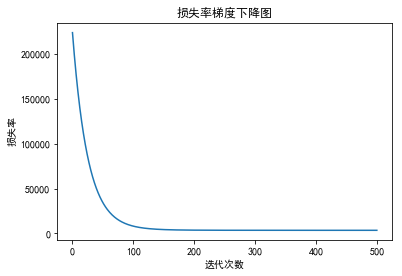

In [11]:
#画出梯度下降
plt.plot(range(num_iterations), cost_history)
plt.xlabel('迭代次数')
plt.ylabel('损失率')
plt.title('损失率梯度下降图')
plt.show()

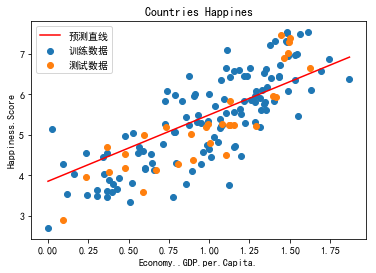

In [12]:
#用自己构建的模型去进行预测，绘制出模型预测直线

predictions_num = 100
x_predictions = np.linspace(x_train.min(), x_train.max(), predictions_num).reshape(predictions_num, 1)
y_predictions = linear_regression.predict(x_predictions)

plt.scatter(x_train, y_train, label='训练数据')
plt.scatter(x_test, y_test, label='测试数据')
plt.plot(x_predictions, y_predictions, 'r', label='预测直线')
plt.xlabel('Economy..GDP.per.Capita.')
plt.ylabel('Happiness.Score')
plt.title('Countries Happines')
plt.legend()
plt.show()

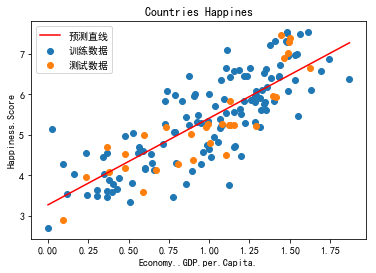

斜率为: [[2.1349492]]
截距为: [3.2727537]


In [13]:
#用sklearn构建线性回归模型
from sklearn.linear_model import LinearRegression

#创建模型
liner = LinearRegression()
#拟合模型
liner.fit(x_train,y_train)

#预测
y_predictions = liner.predict(x_predictions)

plt.scatter(x_train, y_train, label='训练数据')
plt.scatter(x_test, y_test, label='测试数据')
plt.plot(x_predictions, y_predictions, 'r', label='预测直线')
plt.xlabel('Economy..GDP.per.Capita.')
plt.ylabel('Happiness.Score')
plt.title('Countries Happines')
plt.legend()
plt.show()
print("斜率为:",liner.coef_)
print("截距为:",liner.intercept_)

# 用sklearn训练得到的线性回归方程为:y=2.1349492*x+3.2727537